# Tree segmentation

We use the `<VIRASS.TreeSegmenter>` class to build a deep-learning based tree segmentation model.

### Warping

The nDSM model from LiDAR might not be completely aligned with the satellite. This is a common problem, hard to solve automatically and is due to bad/different ortho-recitification process. 
Here, I used Photoshop to try to match as well as possible the nDSM and satellite manually.
Use the `warping.py` script to generate a (better) aligned version.

<img src="images/nDSM_unwarped.jpeg" width="400">
<img src="images/nDSM_warped.jpeg" width="400">

### VIRASS library
Import `VIRASS` library, which will be used for the entire framework. The library implements all the sub-tasks (tree segmentation, tree species classification, risk analysis, etc.) that will be used later on. 

In [ ]:
# Load the VIRASS library
import ASPIREv as ges

### Generating tree mask ground-truth

We extract a tree mask ground truth of the area, namely $GT_{tree}$. 

$GT_{tree}$ is used for the training and validation of the tree segmentation model.
$GT_{tree}$ is computed as $GT_{tree} = (nDSM > Th_1) \vee (NDVI > Th_2)$ where $Th_1$ and $Th_2$ are thresholds for the NDSM and NDVI, respectively.  
nDSM comes from the previous step. NDVI is calculates from QGIS (even though Python can be used as well)

In [2]:
# Load nDSM and NDVI
nDSM, meta_data = ges.io.open_geoTiFF("_data/trees/3D_modeling/GT/warping/nDSM_warped_alpha.tif")
NDVI = ges.io.open_geoTiFF("_data/NDVI.tif", with_meta_data = False)

# Calculate the tree mask ground truth 
GT_tree_mask = ges.geo_utils.generate_tree_points(nDSM, NDVI, Th1 = 1.3, Th2 = 0.1)
# Export it
ges.io.export_GEOtiff(ges.utils.open_dir("Set <tree_points> saving directory ") + "/GTtree.tif", GT_tree_mask, meta_data) 

Converting to channel_last:
(1, 9022, 12913)-->(9022, 12913, 1)
Converting to channel_last:
(1, 9023, 12914)-->(9023, 12914, 1)
Resizing to same shape
Converting to first:
(9022, 12913, 1)-->(1, 9022, 12913)


We apply a morphological closing to `GT_tree_mask` to "close" the gaps and have a more continous mask

In [3]:
# Morphological closing
# Load the ground truth
GT_tree_mask, meta_data_GT = ges.io.open_geoTiFF("_data/trees/tree_segmentation/GT/GTtree.tif")
GT = ges.tree_segmentation.refine_tree_mask(GT_tree_mask, meta_data)
ges.io.export_GEOtiff("_data/trees/tree_segmentation/GT/GTtree_closed.tif", GT, meta_data)

Converting to channel_last:
(1, 9022, 12913)-->(9022, 12913, 1)


c:\Users\miche\Dropbox\PhD\Projects\GridEyeS\PWD_2\VIRASS\VIRASS\tree_segmentation.py:279: FutureWarning: `selem` is a deprecated argument name for `binary_closing`. It will be removed in version 1.0. Please use `footprint` instead.
  tree_mask = np.expand_dims( morphology.binary_closing(tree_mask[:,:,0],


Converting to first:
(9022, 12913, 1)-->(1, 9022, 12913)


### Import satellite image

Converting to channel_last:
(8, 9023, 12914)-->(9023, 12914, 8)


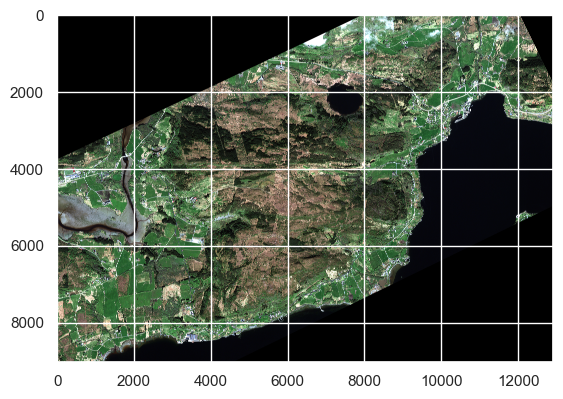

In [6]:
import matplotlib.pyplot as plt
SAT_image, meta_data = ges.io.open_geoTiFF("_data/WorldView_area.tif") 
# Visualize satellite image
plt.imshow(ges.geo_utils.multiband_to_RGB(SAT_image))

## Tree segmentation
Initialize the `TreeSegmenter` class. The behaviour of the class is controlled by the YAML config file.

In [7]:
tree_segmenter = ges.tree_segmentation.TreeSegmenter(config_file = "tree_segmenter_config.yaml")
tree_segmenter.print_attributes()


***class <TreeSegmenter> initialized ***


---Printing class attributes:---
X_map = None
y_map = None
meta_data = None
DLmodel = None
patch_radius = 0
working_dir = C:/Users/miche/Dropbox/PhD/Projects/GridEyeS/PWD_2/VIRASS/_data/trees/tree_segmentation/\
config = {'config_training': {'architecture': 'unet_attention', 'patch_number': 20000, 'patch_radius': 40, 'model_name': 'Unet_attention_segmenter_1_4', 'n_epochs': 200, 'lr': 0.001, 'dropout': True}}




### Loading the data and the model
We load the input image and the ground truth for the training. This is done in QGIS clipping the satellite image and the ground truth based on the training AOI and testing AOI.

In [9]:
tree_segmenter.load_X_map("_data/WorldView_area_training.tif")
tree_segmenter.load_y_map("_data/trees/3D_modeling/GT/GT_nDSM_training.tif")


 Loading X_map
Converting to channel_last:
(8, 8910, 6217)-->(8910, 6217, 8)
X_map shape:(8910, 6217, 8)
X_map loaded 


 Loading y_map
Converting to channel_last:
(1, 8910, 6217)-->(8910, 6217, 1)
Ground truth shape:(8910, 6217, 1)
y_map loaded 



#### Load the model 

The model name is specified in the config file. If the model exists, the class will load it from the disk. If not, it will train a new model.

--Model loaded


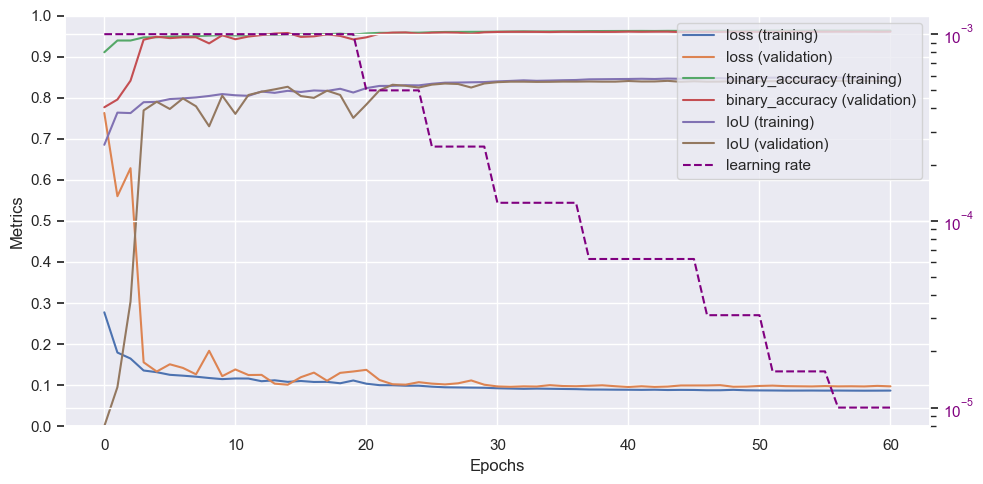

In [10]:
# Load model
tree_segmenter.build_model()
# Plot training history
tree_segmenter.plot_training_history()

### Prediction
When the model is available, we can use it to segment trees over unseen area. If the input is too big, it will be automatically divided into parts, temporarly stored on disk, and stichted them back together.

In [11]:
# Generate tree mask over the testing area
SAT_image, meta_data = ges.io.open_geoTiFF("_data/WorldView_area_testing.tif") 
tree_map_pred = tree_segmenter.generate_tree_map(SAT_image)

Converting to channel_last:
(8, 4746, 3971)-->(4746, 3971, 8)
Estimated memory 2.2466619014739995 GB 

Segmenting trees with tiles smoothing function
Number of patches: 11900
372/372 [==============================] - 8s 10ms/step


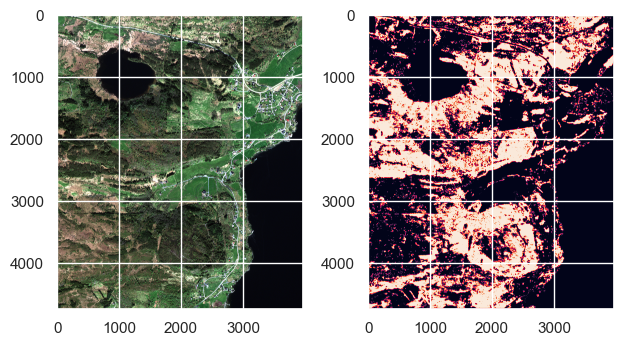

In [12]:
fig, axarr = plt.subplots(1,2)
axarr[0].imshow(ges.geo_utils.multiband_to_RGB(SAT_image))
axarr[1].imshow(tree_map_pred)
plt.tight_layout()

In case we need a binary mask, we can binarize it using a threshold, and export it as geoTIFF, to visualize it in QGIS. 

In [14]:
# Quantize the tree segmentation map
tree_pred_bn = ges.tree_segmentation.binarize_treeMap(tree_map_pred, thresholds = [100])

In [ ]:
# Export it as Geotiff
ges.io.export_GEOtiff("_data/trees/tree_segmentation/tree_pred_testing_" + tree_segmenter.config['config_training']['model_name'] + ".tif", tree_map_pred, meta_data)

### Evaluation

In [15]:
# Load the ground truth for the testing area
GT_test = ges.io.open_geoTiFF("_data/trees/tree_segmentation/GT/GT_tree_testing.tif", with_meta_data = False)
# Compute performance metrics
ges.tree_segmentation.compute_performance(GT_test, tree_pred_bn)

Converting to channel_last:
(1, 4745, 3971)-->(4745, 3971, 1)
X_map shape (4745, 3971, 1) 
y_map shape (4746, 3971, 1)
--Resizing to same shape
SAT shape (4745, 3971, 1) 
y_map shape (4745, 3971, 1)

Accuracy: 0.92
Precision: 0.82
Recall: 0.95
F1-Score: 0.88
ROC AUC: 0.92
Jaccard Index (IoU): 0.79
